First attempt in visualizing implied volatility surface, using a code found from GitHub. Since I did not directly copy the code and tried to code most of the plotting myself, the result is not great. I was not able to get a clean smooth surface but got a spikey surface. The issue potentially is from the excess NAN values I get.

In [164]:
%matplotlib inline
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [165]:
def bs_call_option(S,K,T,r,sigma, q = 0):
    d1 = (np.log(S/K) + (r-q+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call_price = S*np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    return call_price

In [166]:
def implied_vol(price, S, K, T, r, q=0):
    if T<=0 or price <= 0:
        return np.nan
    
    def obj_func(sigma):
        return bs_call_option(S,K,T,r,sigma,q) - price

    try:
        implied_vol = brentq(obj_func, 1e-6,5)
    except (ValueError, RuntimeError):
        implied_vol = np.nan
    return implied_vol

In [167]:
def act365(now_ts, expiry_ts):
    now = pd.to_datetime(now_ts, utc=True)
    exp = pd.to_datetime(expiry_ts, utc=True)
    return (exp - now).days / 365.0

In [168]:
def get_spot(ticker):
    tk = yf.Ticker(ticker)

    try:
        px = tk.fast_info.get("last_rpcie", None)
        if px and px > 0:
            return float(px)
    except Exception:
        pass

    h = tk.history(period = "1d", interval = "1m")
    if not h.empty:
        return float(h["Close"].dropna().iloc[-1])
    info = tk.info
    return float(info.get("regularMarketPrice"))

In [169]:
def get_risk_free():
    try:
        irx = yf.Ticker("^IRX").history(period = "5d")["Close"].dropna().iloc[-1]/100
        r = np.log(1 + float(irx))
        return float(np.clip(r, -0.02, 0.1))
    except Exception:
        return 0.02

In [170]:
def get_dividend_yield(ticker):
    try:
        info = yf.Ticker(ticker).info
        dy = info.get("dividendYield")
        return float(dy) if dy is not None else 0
    except Exception:
        return 0
        

In [171]:
def download_option_chain(ticker):
    tk = yf.Ticker(ticker)
    expiries = tk.options or []
    frames = []
    for ex in expiries:
        oc = tk.option_chain(ex)
        for typ, df in [("C", oc.calls), ("P",oc.puts)]:
            if df is None or df.empty:
                continue
            d = df.copy()
            d["type"] = typ
            d["expiration"] = pd.to_datetime(ex)
            frames.append(d)
    return pd.concat(frames, ignore_index = True) if frames else pd.DataFrame()

In [172]:
def clean_and_prep(raw, ticker, infer_q=True):
    if raw.empty:
        return raw

    now = pd.Timestamp.now(tz="UTC").normalize()


    spot = get_spot(ticker)
    r = get_risk_free()     
    q_guess = get_dividend_yield(ticker)

    df = raw.copy()


    df["expiration"] = pd.to_datetime(df["expiration"], utc=True)


    mid = df["bid"].notna() & df["ask"].notna() & (df["bid"] >= 0) & (df["ask"] >= 0)
    df["mid"] = np.where(mid, 0.5*(df["bid"] + df["ask"]), np.nan)
    df["price"] = df["mid"].where(df["mid"].notna(), df["lastPrice"])

   
    df["T"] = df["expiration"].apply(lambda ex: max(act365(now, ex), 1/3650))


    df = df[(df["strike"] > 0) & (df["price"] > 0)]
    ok_spread = (~mid) | ((df["ask"] - df["bid"]) <= 0.6*df["price"])
    df = df[ok_spread]
    liq = (df["openInterest"].fillna(0) > 0) | (df["volume"].fillna(0) > 0) | mid
    df = df[liq]


    df["spot"] = spot
    df["r"] = r
    df["q"] = q_guess


    df["price_call_equiv"] = np.where(
        df["type"] == "C",
        df["price"],
        df["price"] + df["spot"]*np.exp(-df["q"]*df["T"]) - df["strike"]*np.exp(-df["r"]*df["T"])
    )

    out = df[[
        "expiration","T","type","strike","bid","ask","price","price_call_equiv",
        "openInterest","volume","impliedVolatility","spot","r","q"
    ]].reset_index(drop=True)
    return out


In [173]:
def add_implied_vols(df):
    df = df.copy()
    ivs = []
    for _, row in df.iterrows():
        S = float(row["spot"])
        K = float(row["strike"])          
        T = float(row["T"])
        r = float(row["r"])
        q = float(row["q"])
        C_mkt = float(row["price_call_equiv"])
        iv = implied_vol(C_mkt, S, K, T, r, q)
        ivs.append(iv)

    df["iv"] = ivs
    df = df[(df["iv"] > 1e-4) & (df["iv"] < 3.0)]

  
    F = df["spot"] * np.exp((df["r"] - df["q"]) * df["T"])
    df["k"] = np.log(df["strike"] / F)    
    return df


In [174]:
def make_surface_grid(df, n_T = 40, n_k = 60):
    T_vals = np.linspace(df["T"].min(), df["T"].max(), n_T)
    k_low, k_high = df["k"].quantile(0.05), df["k"].quantile(0.95)
    k_vals = np.linspace(k_low,k_high,n_k)
    TT,KK = np.meshgrid(T_vals, k_vals, indexing = "xy")
    points = np.column_stack((df["T"].values, df["k"].values))
    IV_grid = griddata(points, df["iv"].values, (TT,KK), method = "linear")
    return TT, KK, IV_grid

In [175]:
def plot_surface(TT,KK,IV):
    fig = plt.figure(figsize = (9,6))
    ax = fig.add_subplot(111, projection = "3d")
    ax.plot_surface(TT, KK, IV, rstride = 1, cstride = 1, linewidth = 0, antialiased = True)
    ax.set_xlabel("T (years)")
    ax.set_ylabel("log-moneyness k = ln(K/F)")
    ax.set_zlabel("Implied Volatility")
    plt.title("Implied Volatitlity Surface")
    plt.show()

In [176]:
def plot_surface_plotly(TT,KK,IV):
    fig = go.Figure(data=[go.Surface(x=TT, y=KK, z=IV)])
    fig.update_layout(
        title="Implied Volatility Surface",
        scene=dict(
            xaxis_title="T (years)",
            yaxis_title="log-moneyness (k)",
            zaxis_title="Implied Volatility"
        ),
        height=700
    )
    fig.show()

/var/folders/fn/0hmfgb4j61sfpt2xlmppq1l80000gn/T/ipykernel_1094/3737508671.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[ok_spread]
/var/folders/fn/0hmfgb4j61sfpt2xlmppq1l80000gn/T/ipykernel_1094/3737508671.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[liq]


SPY: rows after cleaning & IV solve = 4593
                  expiration type  strike         T  price  price_call_equiv  \
52 2025-09-22 00:00:00+00:00    C   663.0  0.000274  3.415          3.415000   
53 2025-09-22 00:00:00+00:00    C   664.0  0.000274  2.440          2.440000   
54 2025-09-22 00:00:00+00:00    C   665.0  0.000274  1.505          1.505000   
55 2025-09-22 00:00:00+00:00    C   666.0  0.000274  0.745          0.745000   
56 2025-09-22 00:00:00+00:00    C   667.0  0.000274  0.255          0.255000   
57 2025-09-22 00:00:00+00:00    C   668.0  0.000274  0.075          0.075000   
58 2025-09-22 00:00:00+00:00    C   669.0  0.000274  0.025          0.025000   
59 2025-09-22 00:00:00+00:00    P   652.0  0.000274  0.025         14.438977   
60 2025-09-22 00:00:00+00:00    P   653.0  0.000274  0.025         13.438988   
61 2025-09-22 00:00:00+00:00    P   654.0  0.000274  0.025         12.438998   

          iv         k  
52  0.110603 -0.005136  
53  0.128905 -0.003629  
5

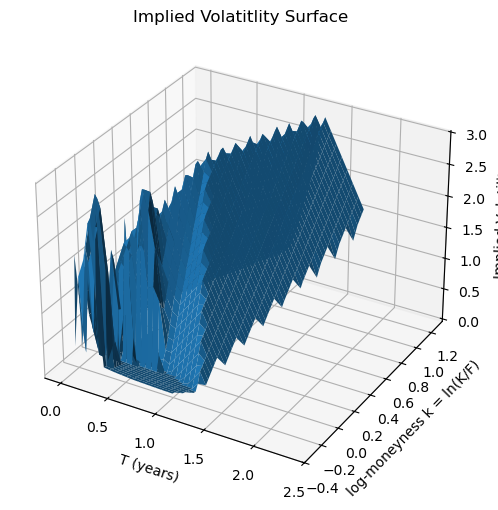

In [177]:
if __name__ == "__main__":
    ticker = "SPY" # Change to get the volatility surface of the desired Underlying     
    infer_q = True           

    raw = download_option_chain(ticker)
    if raw.empty:
        raise RuntimeError("No option data returned. Try another ticker.")

    chain = clean_and_prep(raw, ticker, infer_q=infer_q)
    iv_df = add_implied_vols(chain)

    print(f"{ticker}: rows after cleaning & IV solve = {len(iv_df)}")
    print(iv_df.head(10)[["expiration","type","strike","T","price","price_call_equiv","iv","k"]])

    TT, KK, IV = make_surface_grid(iv_df)
    plot_surface(TT, KK, IV)  